In [ ]:
# Part B Question 2 ----- Completed!

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers, optimizers
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor

In [2]:
NUM_CLASSES = 7

epochs = 1000
batch_size = 8
num_neurons = 10
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

In [39]:
#read and divide data into test and train sets 
admit_data = np.genfromtxt('admission_predict.csv', delimiter= ',')
X_data, Y_data = admit_data[1:,1:8], admit_data[1:,-1]
Y_data = Y_data.reshape(Y_data.shape[0], 1)

df = pd.read_csv('admission_predict.csv')


idx = np.arange(X_data.shape[0])
np.random.shuffle(idx)
X_data, Y_data = X_data[idx], Y_data[idx]

trainX, trainY = X_data, Y_data

trainX = (trainX- np.mean(trainX, axis=0))/ np.std(trainX, axis=0)

# # Split data into 70:30 ratio for training and testing: (280, 7) (280, 1) (120, 7) (120, 1)
trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.3, random_state=seed)

In [40]:
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(280, 7) (120, 7) (280, 1) (120, 1)


In [41]:
col = df.columns
col = np.array(col.drop(['Serial No.', 'Chance of Admit']))

In [54]:
NUM_CLASSES = 7

res = {}
scores = []
output_df = pd.DataFrame(index=col)
num_features = []
for i in range(2, NUM_CLASSES + 1):
    num_features.append(i)
    rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
    model = DecisionTreeRegressor()
    pipe = Pipeline([('Feature Selection', rfe), ('Model', model)])
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=seed)
    n_scores = cross_val_score(pipe, trainX, trainY, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    scores.append(n_scores)
    print('No. of features: %s, MSE: %.6f, Std: %.6f' % (i, np.mean(n_scores), np.std(n_scores)))
    pipe.fit(trainX, trainY)
    output_df[f'Rank ({str(i)})'] = rfe.support_
    res[i] = rfe

output_df

No. of features: 2, MSE: -0.010310, Std: 0.003465
No. of features: 3, MSE: -0.010423, Std: 0.003310
No. of features: 4, MSE: -0.010051, Std: 0.002876
No. of features: 5, MSE: -0.009787, Std: 0.003379
No. of features: 6, MSE: -0.009482, Std: 0.003163
No. of features: 7, MSE: -0.009408, Std: 0.002798


,Rank (2),Rank (3),Rank (4),Rank (5),Rank (6),Rank (7)
GRE Score,True,True,True,True,True,True
TOEFL Score,False,True,True,True,True,True
University Rating,False,False,False,False,True,True
SOP,False,False,True,True,True,True
LOR,False,False,False,True,True,True
CGPA,True,True,True,True,True,True
Research,False,False,False,False,False,True


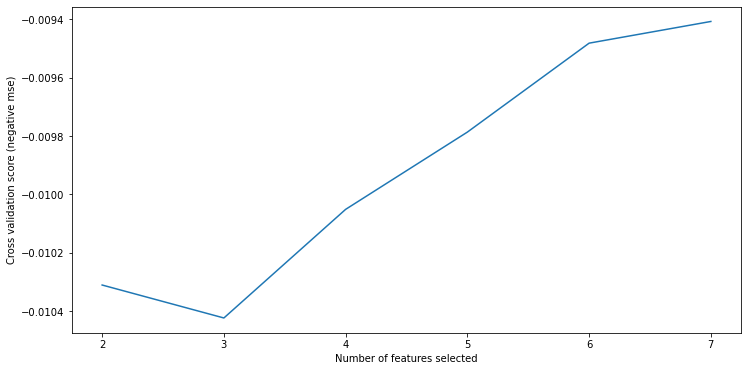

In [56]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (negative mse)')
plt.plot(num_features, [np.mean(score) for score in scores])
plt.savefig('./plots/partb/q2/2_optimal_num_features.png')
plt.show()

In [57]:
cols_to_drop = [np.where(res[num_features].support_ == False)[0] for num_features in [7, 6, 5]]
cols_to_drop

[array([], dtype=int64), array([6]), array([2, 6])]

In [58]:
trainX_list = [np.delete(trainX, cols, 1) for cols in cols_to_drop]
testX_list = [np.delete(testX, cols, 1) for cols in cols_to_drop]

In [59]:
histories={}
num_features = [7, 6, 5]

reg = regularizers.l2(10e-3)
opt = keras.optimizers.SGD(learning_rate=10e-3)

for train_x, test_x, num_feature in zip(trainX_list, testX_list, num_features):
    model = keras.Sequential([keras.layers.Dense(num_neurons, kernel_regularizer=reg, activation='relu'),
                              keras.layers.Dense(1, activation='linear')])

    model.compile(optimizer=opt, loss=keras.losses.MeanSquaredError(), metrics=['mse'])
    
    # learn the network
    histories[num_feature] = model.fit(train_x, trainY,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       validation_data=(test_x, testY),
                                       verbose = 2)

Epoch 1/1000
35/35 - 0s - loss: 0.3935 - mse: 0.3079 - val_loss: 0.2228 - val_mse: 0.1386
Epoch 2/1000
35/35 - 0s - loss: 0.2057 - mse: 0.1226 - val_loss: 0.1595 - val_mse: 0.0774
Epoch 3/1000
35/35 - 0s - loss: 0.1570 - mse: 0.0758 - val_loss: 0.1318 - val_mse: 0.0515
Epoch 4/1000
35/35 - 0s - loss: 0.1335 - mse: 0.0540 - val_loss: 0.1168 - val_mse: 0.0381
Epoch 5/1000
35/35 - 0s - loss: 0.1199 - mse: 0.0419 - val_loss: 0.1070 - val_mse: 0.0297
Epoch 6/1000
35/35 - 0s - loss: 0.1102 - mse: 0.0337 - val_loss: 0.1007 - val_mse: 0.0249
Epoch 7/1000
35/35 - 0s - loss: 0.1040 - mse: 0.0288 - val_loss: 0.0948 - val_mse: 0.0202
Epoch 8/1000
35/35 - 0s - loss: 0.0990 - mse: 0.0251 - val_loss: 0.0909 - val_mse: 0.0176
Epoch 9/1000
35/35 - 0s - loss: 0.0949 - mse: 0.0222 - val_loss: 0.0877 - val_mse: 0.0156
Epoch 10/1000
35/35 - 0s - loss: 0.0916 - mse: 0.0201 - val_loss: 0.0850 - val_mse: 0.0141
Epoch 11/1000
35/35 - 0s - loss: 0.0886 - mse: 0.0183 - val_loss: 0.0826 - val_mse: 0.0129
Epoch 12

35/35 - 0s - loss: 0.0266 - mse: 0.0046 - val_loss: 0.0263 - val_mse: 0.0045
Epoch 92/1000
35/35 - 0s - loss: 0.0263 - mse: 0.0046 - val_loss: 0.0261 - val_mse: 0.0045
Epoch 93/1000
35/35 - 0s - loss: 0.0260 - mse: 0.0046 - val_loss: 0.0257 - val_mse: 0.0045
Epoch 94/1000
35/35 - 0s - loss: 0.0257 - mse: 0.0046 - val_loss: 0.0254 - val_mse: 0.0045
Epoch 95/1000
35/35 - 0s - loss: 0.0254 - mse: 0.0046 - val_loss: 0.0251 - val_mse: 0.0045
Epoch 96/1000
35/35 - 0s - loss: 0.0251 - mse: 0.0046 - val_loss: 0.0248 - val_mse: 0.0045
Epoch 97/1000
35/35 - 0s - loss: 0.0248 - mse: 0.0046 - val_loss: 0.0245 - val_mse: 0.0044
Epoch 98/1000
35/35 - 0s - loss: 0.0245 - mse: 0.0046 - val_loss: 0.0243 - val_mse: 0.0044
Epoch 99/1000
35/35 - 0s - loss: 0.0242 - mse: 0.0045 - val_loss: 0.0240 - val_mse: 0.0044
Epoch 100/1000
35/35 - 0s - loss: 0.0239 - mse: 0.0045 - val_loss: 0.0237 - val_mse: 0.0044
Epoch 101/1000
35/35 - 0s - loss: 0.0236 - mse: 0.0045 - val_loss: 0.0234 - val_mse: 0.0044
Epoch 102/1

Epoch 181/1000
35/35 - 0s - loss: 0.0105 - mse: 0.0040 - val_loss: 0.0102 - val_mse: 0.0038
Epoch 182/1000
35/35 - 0s - loss: 0.0104 - mse: 0.0040 - val_loss: 0.0101 - val_mse: 0.0038
Epoch 183/1000
35/35 - 0s - loss: 0.0103 - mse: 0.0040 - val_loss: 0.0100 - val_mse: 0.0038
Epoch 184/1000
35/35 - 0s - loss: 0.0102 - mse: 0.0040 - val_loss: 0.0100 - val_mse: 0.0038
Epoch 185/1000
35/35 - 0s - loss: 0.0101 - mse: 0.0040 - val_loss: 0.0099 - val_mse: 0.0038
Epoch 186/1000
35/35 - 0s - loss: 0.0100 - mse: 0.0040 - val_loss: 0.0098 - val_mse: 0.0038
Epoch 187/1000
35/35 - 0s - loss: 0.0100 - mse: 0.0040 - val_loss: 0.0097 - val_mse: 0.0038
Epoch 188/1000
35/35 - 0s - loss: 0.0099 - mse: 0.0040 - val_loss: 0.0096 - val_mse: 0.0038
Epoch 189/1000
35/35 - 0s - loss: 0.0098 - mse: 0.0040 - val_loss: 0.0096 - val_mse: 0.0038
Epoch 190/1000
35/35 - 0s - loss: 0.0097 - mse: 0.0040 - val_loss: 0.0095 - val_mse: 0.0038
Epoch 191/1000
35/35 - 0s - loss: 0.0097 - mse: 0.0040 - val_loss: 0.0094 - val_

35/35 - 0s - loss: 0.0061 - mse: 0.0039 - val_loss: 0.0057 - val_mse: 0.0036
Epoch 271/1000
35/35 - 0s - loss: 0.0060 - mse: 0.0039 - val_loss: 0.0057 - val_mse: 0.0036
Epoch 272/1000
35/35 - 0s - loss: 0.0060 - mse: 0.0039 - val_loss: 0.0057 - val_mse: 0.0036
Epoch 273/1000
35/35 - 0s - loss: 0.0060 - mse: 0.0039 - val_loss: 0.0057 - val_mse: 0.0036
Epoch 274/1000
35/35 - 0s - loss: 0.0060 - mse: 0.0039 - val_loss: 0.0056 - val_mse: 0.0036
Epoch 275/1000
35/35 - 0s - loss: 0.0059 - mse: 0.0039 - val_loss: 0.0056 - val_mse: 0.0036
Epoch 276/1000
35/35 - 0s - loss: 0.0059 - mse: 0.0039 - val_loss: 0.0056 - val_mse: 0.0036
Epoch 277/1000
35/35 - 0s - loss: 0.0059 - mse: 0.0039 - val_loss: 0.0056 - val_mse: 0.0036
Epoch 278/1000
35/35 - 0s - loss: 0.0059 - mse: 0.0039 - val_loss: 0.0055 - val_mse: 0.0036
Epoch 279/1000
35/35 - 0s - loss: 0.0058 - mse: 0.0039 - val_loss: 0.0055 - val_mse: 0.0036
Epoch 280/1000
35/35 - 0s - loss: 0.0058 - mse: 0.0039 - val_loss: 0.0055 - val_mse: 0.0036
Epo

Epoch 360/1000
35/35 - 0s - loss: 0.0048 - mse: 0.0039 - val_loss: 0.0045 - val_mse: 0.0036
Epoch 361/1000
35/35 - 0s - loss: 0.0048 - mse: 0.0039 - val_loss: 0.0045 - val_mse: 0.0036
Epoch 362/1000
35/35 - 0s - loss: 0.0048 - mse: 0.0039 - val_loss: 0.0045 - val_mse: 0.0036
Epoch 363/1000
35/35 - 0s - loss: 0.0048 - mse: 0.0039 - val_loss: 0.0045 - val_mse: 0.0036
Epoch 364/1000
35/35 - 0s - loss: 0.0048 - mse: 0.0039 - val_loss: 0.0045 - val_mse: 0.0036
Epoch 365/1000
35/35 - 0s - loss: 0.0048 - mse: 0.0039 - val_loss: 0.0044 - val_mse: 0.0036
Epoch 366/1000
35/35 - 0s - loss: 0.0048 - mse: 0.0039 - val_loss: 0.0044 - val_mse: 0.0036
Epoch 367/1000
35/35 - 0s - loss: 0.0048 - mse: 0.0039 - val_loss: 0.0044 - val_mse: 0.0036
Epoch 368/1000
35/35 - 0s - loss: 0.0048 - mse: 0.0039 - val_loss: 0.0044 - val_mse: 0.0036
Epoch 369/1000
35/35 - 0s - loss: 0.0048 - mse: 0.0039 - val_loss: 0.0044 - val_mse: 0.0036
Epoch 370/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0039 - val_loss: 0.0044 - val_

35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0035
Epoch 450/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0036
Epoch 451/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0036
Epoch 452/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0036
Epoch 453/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0036
Epoch 454/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0036
Epoch 455/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0036
Epoch 456/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0036
Epoch 457/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0035
Epoch 458/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0036
Epoch 459/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0039 - val_loss: 0.0041 - val_mse: 0.0036
Epo

Epoch 539/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0035
Epoch 540/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0035
Epoch 541/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 542/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 543/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0035
Epoch 544/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0035
Epoch 545/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0035
Epoch 546/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0035
Epoch 547/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 548/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 549/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_

35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 629/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 630/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 631/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 632/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 633/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 634/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 635/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 636/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0035
Epoch 637/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 638/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epo

Epoch 718/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 719/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 720/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 721/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 722/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 723/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 724/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 725/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 726/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 727/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 728/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_

35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 808/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 809/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 810/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 811/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 812/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 813/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 814/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 815/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 816/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 817/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epo

Epoch 897/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 898/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 899/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0037
Epoch 900/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 901/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 902/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 903/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 904/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0039 - val_mse: 0.0036
Epoch 905/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 906/1000
35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 907/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0039 - val_

35/35 - 0s - loss: 0.0042 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 987/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0039 - val_mse: 0.0036
Epoch 988/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 989/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0039 - val_mse: 0.0036
Epoch 990/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 991/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 992/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0039 - val_mse: 0.0036
Epoch 993/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0039 - val_mse: 0.0036
Epoch 994/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 995/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epoch 996/1000
35/35 - 0s - loss: 0.0041 - mse: 0.0038 - val_loss: 0.0040 - val_mse: 0.0036
Epo

35/35 - 0s - loss: 0.0251 - mse: 0.0054 - val_loss: 0.0249 - val_mse: 0.0054
Epoch 77/1000
35/35 - 0s - loss: 0.0248 - mse: 0.0054 - val_loss: 0.0246 - val_mse: 0.0053
Epoch 78/1000
35/35 - 0s - loss: 0.0245 - mse: 0.0054 - val_loss: 0.0242 - val_mse: 0.0053
Epoch 79/1000
35/35 - 0s - loss: 0.0242 - mse: 0.0053 - val_loss: 0.0240 - val_mse: 0.0053
Epoch 80/1000
35/35 - 0s - loss: 0.0239 - mse: 0.0053 - val_loss: 0.0237 - val_mse: 0.0053
Epoch 81/1000
35/35 - 0s - loss: 0.0236 - mse: 0.0053 - val_loss: 0.0234 - val_mse: 0.0052
Epoch 82/1000
35/35 - 0s - loss: 0.0233 - mse: 0.0053 - val_loss: 0.0231 - val_mse: 0.0052
Epoch 83/1000
35/35 - 0s - loss: 0.0230 - mse: 0.0052 - val_loss: 0.0228 - val_mse: 0.0052
Epoch 84/1000
35/35 - 0s - loss: 0.0227 - mse: 0.0052 - val_loss: 0.0225 - val_mse: 0.0051
Epoch 85/1000
35/35 - 0s - loss: 0.0224 - mse: 0.0052 - val_loss: 0.0222 - val_mse: 0.0051
Epoch 86/1000
35/35 - 0s - loss: 0.0222 - mse: 0.0052 - val_loss: 0.0219 - val_mse: 0.0050
Epoch 87/1000

Epoch 166/1000
35/35 - 0s - loss: 0.0096 - mse: 0.0042 - val_loss: 0.0093 - val_mse: 0.0039
Epoch 167/1000
35/35 - 0s - loss: 0.0096 - mse: 0.0042 - val_loss: 0.0092 - val_mse: 0.0039
Epoch 168/1000
35/35 - 0s - loss: 0.0095 - mse: 0.0042 - val_loss: 0.0091 - val_mse: 0.0039
Epoch 169/1000
35/35 - 0s - loss: 0.0094 - mse: 0.0042 - val_loss: 0.0091 - val_mse: 0.0039
Epoch 170/1000
35/35 - 0s - loss: 0.0093 - mse: 0.0042 - val_loss: 0.0089 - val_mse: 0.0038
Epoch 171/1000
35/35 - 0s - loss: 0.0093 - mse: 0.0042 - val_loss: 0.0089 - val_mse: 0.0038
Epoch 172/1000
35/35 - 0s - loss: 0.0092 - mse: 0.0042 - val_loss: 0.0089 - val_mse: 0.0039
Epoch 173/1000
35/35 - 0s - loss: 0.0091 - mse: 0.0042 - val_loss: 0.0088 - val_mse: 0.0039
Epoch 174/1000
35/35 - 0s - loss: 0.0091 - mse: 0.0042 - val_loss: 0.0087 - val_mse: 0.0038
Epoch 175/1000
35/35 - 0s - loss: 0.0090 - mse: 0.0042 - val_loss: 0.0086 - val_mse: 0.0038
Epoch 176/1000
35/35 - 0s - loss: 0.0089 - mse: 0.0042 - val_loss: 0.0085 - val_

35/35 - 0s - loss: 0.0058 - mse: 0.0041 - val_loss: 0.0053 - val_mse: 0.0036
Epoch 256/1000
35/35 - 0s - loss: 0.0058 - mse: 0.0041 - val_loss: 0.0052 - val_mse: 0.0035
Epoch 257/1000
35/35 - 0s - loss: 0.0058 - mse: 0.0041 - val_loss: 0.0052 - val_mse: 0.0035
Epoch 258/1000
35/35 - 0s - loss: 0.0057 - mse: 0.0041 - val_loss: 0.0052 - val_mse: 0.0035
Epoch 259/1000
35/35 - 0s - loss: 0.0057 - mse: 0.0041 - val_loss: 0.0052 - val_mse: 0.0035
Epoch 260/1000
35/35 - 0s - loss: 0.0057 - mse: 0.0041 - val_loss: 0.0051 - val_mse: 0.0035
Epoch 261/1000
35/35 - 0s - loss: 0.0057 - mse: 0.0041 - val_loss: 0.0052 - val_mse: 0.0036
Epoch 262/1000
35/35 - 0s - loss: 0.0057 - mse: 0.0041 - val_loss: 0.0051 - val_mse: 0.0036
Epoch 263/1000
35/35 - 0s - loss: 0.0056 - mse: 0.0041 - val_loss: 0.0051 - val_mse: 0.0035
Epoch 264/1000
35/35 - 0s - loss: 0.0056 - mse: 0.0041 - val_loss: 0.0051 - val_mse: 0.0036
Epoch 265/1000
35/35 - 0s - loss: 0.0056 - mse: 0.0041 - val_loss: 0.0050 - val_mse: 0.0035
Epo

Epoch 345/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0035
Epoch 346/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0035
Epoch 347/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0035
Epoch 348/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0035
Epoch 349/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0036
Epoch 350/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0036
Epoch 351/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0035
Epoch 352/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0035
Epoch 353/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0036
Epoch 354/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0035
Epoch 355/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0040 - val_

35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0038 - val_mse: 0.0035
Epoch 435/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0038 - val_mse: 0.0035
Epoch 436/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0039 - val_mse: 0.0035
Epoch 437/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0039 - val_mse: 0.0036
Epoch 438/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0038 - val_mse: 0.0035
Epoch 439/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0039 - val_mse: 0.0036
Epoch 440/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0038 - val_mse: 0.0035
Epoch 441/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0038 - val_mse: 0.0035
Epoch 442/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0038 - val_mse: 0.0035
Epoch 443/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0038 - val_mse: 0.0035
Epoch 444/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0038 - val_mse: 0.0035
Epo

Epoch 524/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0038 - val_mse: 0.0035
Epoch 525/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 526/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 527/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 528/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 529/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 530/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0034
Epoch 531/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 532/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 533/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 534/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_

35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 614/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 615/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 616/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 617/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 618/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 619/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 620/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 621/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 622/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 623/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epo

Epoch 703/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 704/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0035
Epoch 705/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 706/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 707/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 708/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 709/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 710/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 711/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 712/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0035
Epoch 713/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0037 - val_

35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 793/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 794/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0035
Epoch 795/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 796/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 797/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 798/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0035
Epoch 799/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 800/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0035
Epoch 801/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 802/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epo

Epoch 882/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 883/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 884/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0035
Epoch 885/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 886/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 887/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 888/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 889/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0035
Epoch 890/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 891/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0035
Epoch 892/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_

35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0035
Epoch 972/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0035
Epoch 973/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 974/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 975/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 976/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 977/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 978/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 979/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 980/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 981/1000
35/35 - 0s - loss: 0.0043 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0034
Epo

Epoch 61/1000
35/35 - 0s - loss: 0.0306 - mse: 0.0051 - val_loss: 0.0311 - val_mse: 0.0058
Epoch 62/1000
35/35 - 0s - loss: 0.0302 - mse: 0.0051 - val_loss: 0.0307 - val_mse: 0.0058
Epoch 63/1000
35/35 - 0s - loss: 0.0298 - mse: 0.0050 - val_loss: 0.0304 - val_mse: 0.0057
Epoch 64/1000
35/35 - 0s - loss: 0.0295 - mse: 0.0050 - val_loss: 0.0300 - val_mse: 0.0057
Epoch 65/1000
35/35 - 0s - loss: 0.0291 - mse: 0.0050 - val_loss: 0.0295 - val_mse: 0.0056
Epoch 66/1000
35/35 - 0s - loss: 0.0287 - mse: 0.0049 - val_loss: 0.0292 - val_mse: 0.0056
Epoch 67/1000
35/35 - 0s - loss: 0.0284 - mse: 0.0049 - val_loss: 0.0288 - val_mse: 0.0055
Epoch 68/1000
35/35 - 0s - loss: 0.0280 - mse: 0.0049 - val_loss: 0.0284 - val_mse: 0.0055
Epoch 69/1000
35/35 - 0s - loss: 0.0276 - mse: 0.0049 - val_loss: 0.0281 - val_mse: 0.0055
Epoch 70/1000
35/35 - 0s - loss: 0.0273 - mse: 0.0048 - val_loss: 0.0277 - val_mse: 0.0054
Epoch 71/1000
35/35 - 0s - loss: 0.0270 - mse: 0.0048 - val_loss: 0.0274 - val_mse: 0.0054

Epoch 151/1000
35/35 - 0s - loss: 0.0116 - mse: 0.0042 - val_loss: 0.0115 - val_mse: 0.0042
Epoch 152/1000
35/35 - 0s - loss: 0.0115 - mse: 0.0042 - val_loss: 0.0114 - val_mse: 0.0042
Epoch 153/1000
35/35 - 0s - loss: 0.0114 - mse: 0.0042 - val_loss: 0.0113 - val_mse: 0.0041
Epoch 154/1000
35/35 - 0s - loss: 0.0113 - mse: 0.0042 - val_loss: 0.0112 - val_mse: 0.0042
Epoch 155/1000
35/35 - 0s - loss: 0.0112 - mse: 0.0042 - val_loss: 0.0111 - val_mse: 0.0042
Epoch 156/1000
35/35 - 0s - loss: 0.0111 - mse: 0.0042 - val_loss: 0.0110 - val_mse: 0.0041
Epoch 157/1000
35/35 - 0s - loss: 0.0110 - mse: 0.0042 - val_loss: 0.0109 - val_mse: 0.0041
Epoch 158/1000
35/35 - 0s - loss: 0.0109 - mse: 0.0042 - val_loss: 0.0108 - val_mse: 0.0042
Epoch 159/1000
35/35 - 0s - loss: 0.0108 - mse: 0.0042 - val_loss: 0.0107 - val_mse: 0.0041
Epoch 160/1000
35/35 - 0s - loss: 0.0107 - mse: 0.0042 - val_loss: 0.0106 - val_mse: 0.0041
Epoch 161/1000
35/35 - 0s - loss: 0.0106 - mse: 0.0042 - val_loss: 0.0105 - val_

35/35 - 0s - loss: 0.0066 - mse: 0.0041 - val_loss: 0.0064 - val_mse: 0.0040
Epoch 241/1000
35/35 - 0s - loss: 0.0065 - mse: 0.0041 - val_loss: 0.0064 - val_mse: 0.0040
Epoch 242/1000
35/35 - 0s - loss: 0.0065 - mse: 0.0041 - val_loss: 0.0063 - val_mse: 0.0040
Epoch 243/1000
35/35 - 0s - loss: 0.0065 - mse: 0.0041 - val_loss: 0.0063 - val_mse: 0.0040
Epoch 244/1000
35/35 - 0s - loss: 0.0065 - mse: 0.0041 - val_loss: 0.0063 - val_mse: 0.0040
Epoch 245/1000
35/35 - 0s - loss: 0.0064 - mse: 0.0041 - val_loss: 0.0062 - val_mse: 0.0039
Epoch 246/1000
35/35 - 0s - loss: 0.0064 - mse: 0.0041 - val_loss: 0.0062 - val_mse: 0.0039
Epoch 247/1000
35/35 - 0s - loss: 0.0064 - mse: 0.0041 - val_loss: 0.0062 - val_mse: 0.0039
Epoch 248/1000
35/35 - 0s - loss: 0.0064 - mse: 0.0041 - val_loss: 0.0062 - val_mse: 0.0040
Epoch 249/1000
35/35 - 0s - loss: 0.0063 - mse: 0.0041 - val_loss: 0.0061 - val_mse: 0.0040
Epoch 250/1000
35/35 - 0s - loss: 0.0063 - mse: 0.0041 - val_loss: 0.0061 - val_mse: 0.0040
Epo

Epoch 330/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0049 - val_mse: 0.0039
Epoch 331/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0049 - val_mse: 0.0039
Epoch 332/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0049 - val_mse: 0.0039
Epoch 333/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0049 - val_mse: 0.0039
Epoch 334/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0048 - val_mse: 0.0039
Epoch 335/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0048 - val_mse: 0.0039
Epoch 336/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0048 - val_mse: 0.0039
Epoch 337/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0049 - val_mse: 0.0039
Epoch 338/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0048 - val_mse: 0.0039
Epoch 339/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0048 - val_mse: 0.0039
Epoch 340/1000
35/35 - 0s - loss: 0.0051 - mse: 0.0041 - val_loss: 0.0048 - val_

35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 420/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 421/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 422/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 423/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 424/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 425/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 426/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 427/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 428/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 429/1000
35/35 - 0s - loss: 0.0047 - mse: 0.0041 - val_loss: 0.0043 - val_mse: 0.0038
Epo

Epoch 509/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0037
Epoch 510/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0037
Epoch 511/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0037
Epoch 512/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0037
Epoch 513/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0037
Epoch 514/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0037
Epoch 515/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0037
Epoch 516/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0037
Epoch 517/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0037
Epoch 518/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0037
Epoch 519/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_

35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0038
Epoch 599/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 600/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 601/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 602/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 603/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 604/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 605/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 606/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0042 - val_mse: 0.0038
Epoch 607/1000
35/35 - 0s - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0038
Epoch 608/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0042 - val_mse: 0.0038
Epo

Epoch 688/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 689/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 690/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 691/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 692/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 693/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 694/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 695/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 696/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 697/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 698/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0041 - val_

35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 778/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 779/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 780/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0037
Epoch 781/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 782/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 783/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 784/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0038
Epoch 785/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 786/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 787/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0037
Epo

Epoch 867/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 868/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 869/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 870/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0037
Epoch 871/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 872/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0037
Epoch 873/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 874/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 875/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 876/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 877/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_

Epoch 957/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 958/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0037
Epoch 959/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0037
Epoch 960/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0037
Epoch 961/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0037
Epoch 962/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 963/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 964/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 965/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0037
Epoch 966/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0037
Epoch 967/1000
35/35 - 0s - loss: 0.0044 - mse: 0.0040 - val_loss: 0.0040 - val_

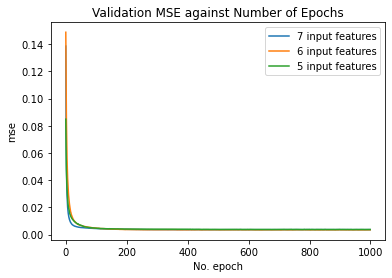

In [66]:
# plot learning curves
for num_feature in num_features:
    plt.plot(histories[num_feature].history['val_mse'], label=f'{num_feature} input features')
plt.title('Validation MSE against Number of Epochs')
plt.ylabel('mse')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.savefig('./plots/partb/q2/2_val_mse.png')
plt.show()

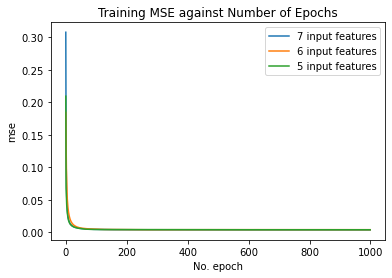

In [65]:
# plot learning curves
for num_feature in num_features:
    plt.plot(histories[num_feature].history['mse'], label=f'{num_feature} input features')
plt.title('Training MSE against Number of Epochs')
plt.ylabel('mse')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.savefig('./plots/partb/q2/2_train_mse.png')
plt.show()

In [63]:
print('Final Results for different number of input features \n')
for i in num_features:
    final_val_mse = histories[i].history['val_mse'][epochs-1]
    final_mse = histories[i].history['mse'][epochs-1]
    final_val_loss = histories[i].history['val_loss'][epochs-1]
    final_loss = histories[i].history['loss'][epochs-1]
    print('No. of features: %s, Val_MSE: %.6f, MSE: %.6f, Val_Loss: %.6f, Loss: %.6f' % (i, final_val_mse, final_mse, final_val_loss, final_loss))

Final Results for different number of input features 

No. of features: 7, Val_MSE: 0.003599, MSE: 0.003774, Val_Loss: 0.003959, Loss: 0.004134
No. of features: 6, Val_MSE: 0.003460, MSE: 0.004122, Val_Loss: 0.003649, Loss: 0.004310
No. of features: 5, Val_MSE: 0.003705, MSE: 0.004025, Val_Loss: 0.004050, Loss: 0.004369
